# Import Library

In [ ]:
#import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score, precision_score, recall_score, confusion_matrix
import random
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize

import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import pad_sequences
from keras.callbacks import ReduceLROnPlateau

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

Variable | Description
--------------|-----------
subreddit | subreddit is a specific community or forum
post_id | unique id for each user
sentence_range | sentence index that user posted
text |  text used for stress detection
label |  contain 2 variables, 0 - non-stressed, 1 - stressed
confidence |  confidence level of person on text
social_timestamp |  timestamp of social

In [ ]:
df = pd.read_csv('/content/Stress.csv')
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [ ]:
df.shape

(2838, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [ ]:
df.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [ ]:
df['label'].value_counts()

1    1488
0    1350
Name: label, dtype: int64

In [ ]:
df.duplicated().any()

False

EDA

<Axes: xlabel='label', ylabel='count'>

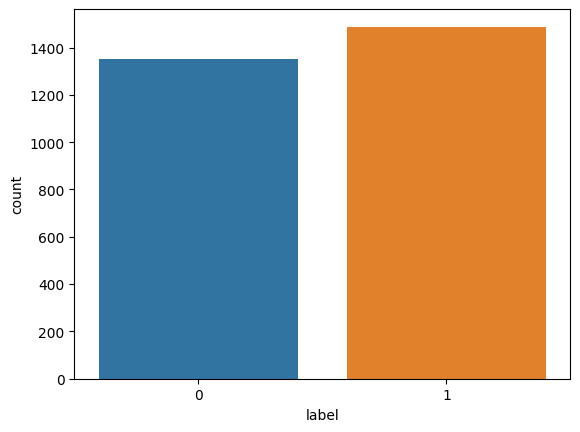

In [ ]:
sns.countplot(x='label',data=df)

In [ ]:
fig = px.pie(df,values='label',names='subreddit')
fig.show()

[Text(0, 0, 'Not Stressed'), Text(1, 0, 'Stressed')]

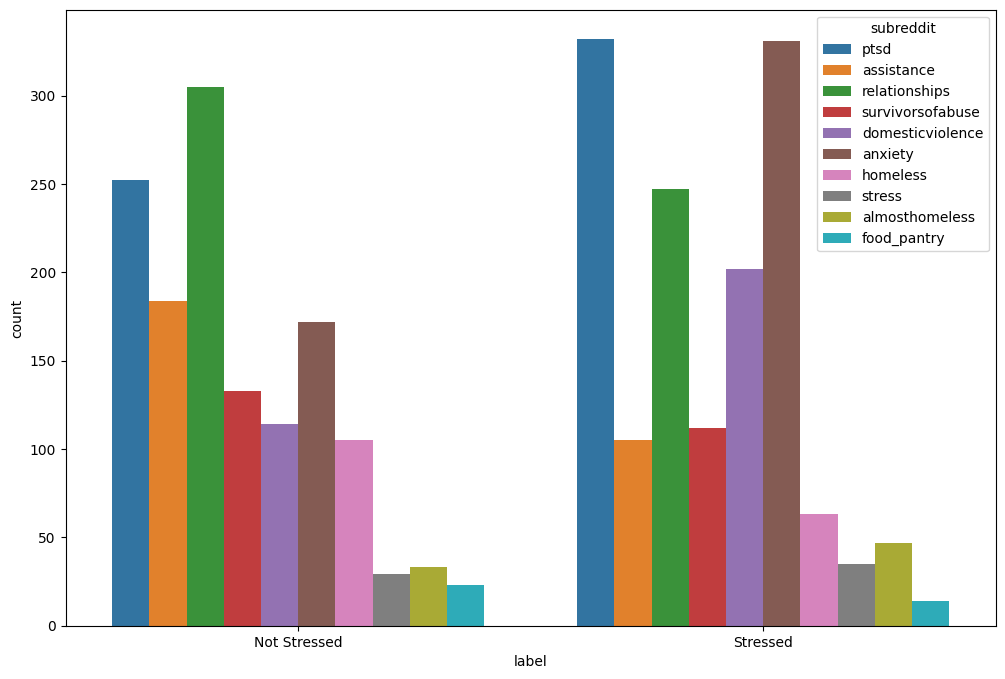

In [ ]:
plt.figure(figsize = (12,8))
chart = sns.countplot(x = "label", hue = "subreddit" , data = df)

chart.set_xticklabels(labels=['Not Stressed','Stressed'],rotation=0)

# Data Preprocessing

In [ ]:

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stop_words.extend(['from','re','subject','edu','use'])

def preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(lemmatizer.lemmatize(token))
  return result

In [ ]:
df['clean_text'] = df['text'].apply(preprocess)

In [ ]:
df['clean_text_joined']=df['clean_text'].apply(lambda x:" ".join(x))

In [ ]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,clean_text,clean_text_joined
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,"[said, felt, way, suggeted, rest, trigger, ahe...",said felt way suggeted rest trigger ahead youi...
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,"[hey, assistance, sure, right, place, post, go...",hey assistance sure right place post go curren...
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,"[mom, hit, newspaper, shocked, know, like, pla...",mom hit newspaper shocked know like play hitti...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,"[met, new, boyfriend, amazing, kind, sweet, go...",met new boyfriend amazing kind sweet good stud...
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,"[october, domestic, violence, awareness, month...",october domestic violence awareness month dome...


In [ ]:
df.to_csv('df.csv', index=False)

# EDA

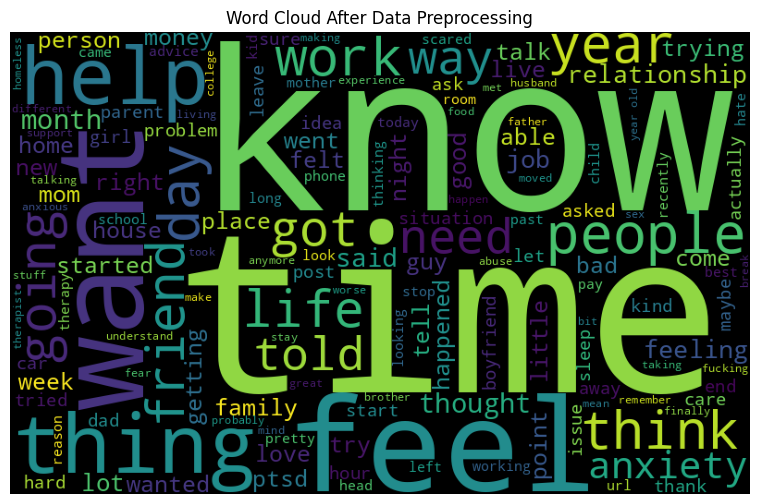

In [ ]:
text = ' '.join(caption for caption in df['clean_text_joined'])
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', min_font_size = 10).generate(text)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.title("Word Cloud After Data Preprocessing")
plt.axis('off')
plt.show();

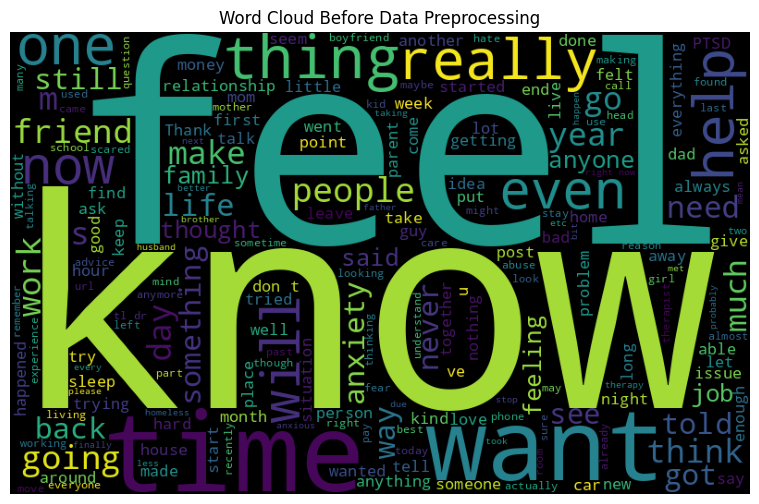

In [ ]:
text = ' '.join(caption for caption in df['text'])
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', min_font_size = 10).generate(text)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Word Cloud Before Data Preprocessing")
plt.show();

# Append Result

In [ ]:
# create for appending result
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Bag of Words (BoW)

In [ ]:
# Split X and Y
X = np.array(df['clean_text_joined'])
Y = np.array(df['label'])

cv = CountVectorizer() # Convert text to numerical
Xbow = cv.fit_transform(X)

# Split Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(Xbow, Y, test_size = 0.20, random_state = 31)

SVM (with BoW)

In [ ]:
# Find the best hyperparameter for SVM
svmB = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
}

grid_search = GridSearchCV(svmB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
svmB_pred = best_model.predict(X_test)
svmB_CR = classification_report(Y_test, svmB_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
svmB_accuracy = accuracy_score(Y_test, svmB_pred)
svmB_precision = precision_score(Y_test, svmB_pred)
svmB_recall = recall_score(Y_test, svmB_pred)
svmB_f1score = f1_score(Y_test, svmB_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of SVM:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of SVM', accuracy_score(Y_test, svmB_pred))

print("")
print("-"*20)
print("")

print(svmB_CR)

accuracies.append(round(svmB_accuracy, 4) * 100)
precisions.append(round(svmB_precision, 4) * 100)
recalls.append(round(svmB_recall, 4) * 100)
f1_scores.append(round(svmB_f1score, 4) * 100)

Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 0.7180616740088105
Best training accuracy of SVM: 0.8819383259911894
Best testing accuracy of SVM 0.7376760563380281

--------------------

              precision    recall  f1-score   support

           0     0.6963    0.7373    0.7162       255
           1     0.7752    0.7380    0.7561       313

    accuracy                         0.7377       568
   macro avg     0.7357    0.7376    0.7362       568
weighted avg     0.7398    0.7377    0.7382       568



In [ ]:
print(svmB_accuracy)
print(svmB_precision)
print(svmB_recall)
print(svmB_f1score)

svmB_cm = confusion_matrix(Y_test, svmB_pred)

print(svmB_cm)

0.7376760563380281
0.7751677852348994
0.7380191693290735
0.7561374795417349
[[188  67]
 [ 82 231]]


LR (with BoW)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
lrB = LogisticRegression(max_iter=1000000, random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear'],  # Solver for logistic regression
}

grid_search = GridSearchCV(lrB, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
lrB_pred = best_model.predict(X_test)
lrB_CR = classification_report(Y_test, lrB_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
lrB_accuracy = accuracy_score(Y_test, lrB_pred)
lrB_precision = precision_score(Y_test, lrB_pred)
lrB_recall = recall_score(Y_test, lrB_pred)
lrB_f1score = f1_score(Y_test, lrB_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of LR:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of LR:', accuracy_score(Y_test, lrB_pred))

print("")
print("-"*20)
print("")

print(lrB_CR)
print("")

print("")
print(lrB_accuracy)
print(lrB_precision)
print(lrB_recall)
print(lrB_f1score)

accuracies.append(round(lrB_accuracy, 4) * 100)
precisions.append(round(lrB_precision, 4) * 100)
recalls.append(round(lrB_recall, 4) * 100)
f1_scores.append(round(lrB_f1score, 4) * 100)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.7264317180616741
Best training accuracy of LR: 0.9295154185022027
Best testing accuracy of LR: 0.7570422535211268

--------------------

              precision    recall  f1-score   support

           0     0.7224    0.7451    0.7336       255
           1     0.7869    0.7668    0.7767       313

    accuracy                         0.7570       568
   macro avg     0.7547    0.7559    0.7551       568
weighted avg     0.7580    0.7570    0.7573       568



0.7570422535211268
0.7868852459016393
0.7667731629392971
0.7766990291262136


In [ ]:
lrB_cm = confusion_matrix(Y_test, lrB_pred)
print(lrB_cm)

[[190  65]
 [ 73 240]]


NB (with BoW)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
nbB = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Example values for the alpha parameter
}

grid_search = GridSearchCV(nbB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
nbB_pred = best_model.predict(X_test)
nbB_CR = classification_report(Y_test, nbB_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
nbB_accuracy = accuracy_score(Y_test, nbB_pred)
nbB_precision = precision_score(Y_test, nbB_pred)
nbB_recall = recall_score(Y_test, nbB_pred)
nbB_f1score = f1_score(Y_test, nbB_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of NB:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of NB:', accuracy_score(Y_test, nbB_pred))

print("")
print("-"*20)
print("")

print(nbB_CR)
print("")

print("")
print(nbB_accuracy)
print(nbB_precision)
print(nbB_recall)
print(nbB_f1score)

accuracies.append(round(nbB_accuracy, 4) * 100)
precisions.append(round(nbB_precision, 4) * 100)
recalls.append(round(nbB_recall, 4) * 100)
f1_scores.append(round(nbB_f1score, 4) * 100)

Best parameters: {'alpha': 1.0}
Best cross-validation score: 0.717180616740088
Best training accuracy of LR: 0.926431718061674
Best testing accuracy of LR: 0.7605633802816901

--------------------

              precision    recall  f1-score   support

           0     0.7847    0.6431    0.7069       255
           1     0.7465    0.8562    0.7976       313

    accuracy                         0.7606       568
   macro avg     0.7656    0.7497    0.7523       568
weighted avg     0.7637    0.7606    0.7569       568



0.7605633802816901
0.7465181058495822
0.8562300319488818
0.7976190476190476


DT (with BoW)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

dtB = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

grid_search = GridSearchCV(dtB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
dtB_pred = best_model.predict(X_test)
dtB_CR = classification_report(Y_test, dtB_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
dtB_accuracy = accuracy_score(Y_test, dtB_pred)
dtB_precision = precision_score(Y_test, dtB_pred)
dtB_recall = recall_score(Y_test, dtB_pred)
dtB_f1score = f1_score(Y_test, dtB_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of DT:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of DT:', accuracy_score(Y_test, dtB_pred))

print("")
print("-"*20)
print("")

print(dtB_CR)
print("")

print("")
print(dtB_accuracy)
print(dtB_precision)
print(dtB_recall)
print(dtB_f1score)

accuracies.append(round(dtB_accuracy, 4) * 100)
precisions.append(round(dtB_precision, 4) * 100)
recalls.append(round(dtB_recall, 4) * 100)
f1_scores.append(round(dtB_f1score, 4) * 100)

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score: 0.6374449339207049
Best training accuracy of LR: 0.8229074889867841
Best testing accuracy of LR: 0.6214788732394366

--------------------

              precision    recall  f1-score   support

           0     0.5658    0.6745    0.6154       255
           1     0.6856    0.5783    0.6274       313

    accuracy                         0.6215       568
   macro avg     0.6257    0.6264    0.6214       568
weighted avg     0.6318    0.6215    0.6220       568



0.6214788732394366
0.6856060606060606
0.5782747603833865
0.6273830155979203


RF (with BoW)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rfB = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

grid_search = GridSearchCV(rfB, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
rfB_pred = best_model.predict(X_test)
rfB_CR = classification_report(Y_test, rfB_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
rfB_accuracy = accuracy_score(Y_test, rfB_pred)
rfB_precision = precision_score(Y_test, rfB_pred)
rfB_recall = recall_score(Y_test, rfB_pred)
rfB_f1score = f1_score(Y_test, rfB_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of RF:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of RF:', accuracy_score(Y_test, rfB_pred))

print("")
print("-"*20)
print("")

print(rfB_CR)
print("")

print("")
print(rfB_accuracy)
print(rfB_precision)
print(rfB_recall)
print(rfB_f1score)

accuracies.append(round(rfB_accuracy, 4) * 100)
precisions.append(round(rfB_precision, 4) * 100)
recalls.append(round(rfB_recall, 4) * 100)
f1_scores.append(round(rfB_f1score, 4) * 100)

Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.7290748898678414
Best training accuracy of LR: 0.8568281938325991
Best testing accuracy of LR: 0.7323943661971831

--------------------

              precision    recall  f1-score   support

           0     0.7269    0.6471    0.6846       255
           1     0.7361    0.8019    0.7676       313

    accuracy                         0.7324       568
   macro avg     0.7315    0.7245    0.7261       568
weighted avg     0.7319    0.7324    0.7304       568



0.7323943661971831
0.7360703812316716
0.8019169329073482
0.7675840978593271


Cross validation result


 SVC(C=10, gamma=0.001)
f1-Score(train): mean= (0.718), min=(0.705)) ,max= (0.740), stdev= (0.013)
f1-Score(test): 0.7181

 LogisticRegression(C=0.1, solver='liblinear')
f1-Score(train): mean= (0.726), min=(0.711)) ,max= (0.744), stdev= (0.012)
f1-Score(test): 0.7262

 MultinomialNB(alpha=0.1)
f1-Score(train): mean= (0.698), min=(0.682)) ,max= (0.737), stdev= (0.020)
f1-Score(test): 0.6985

 DecisionTreeClassifier(max_depth=20, min_samples_split=5)
f1-Score(train): mean= (0.625), min=(0.593)) ,max= (0.683), stdev= (0.033)
f1-Score(test): 0.6324

 RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200)
f1-Score(train): mean= (0.715), min=(0.704)) ,max= (0.729), stdev= (0.009)
f1-Score(test): 0.7265


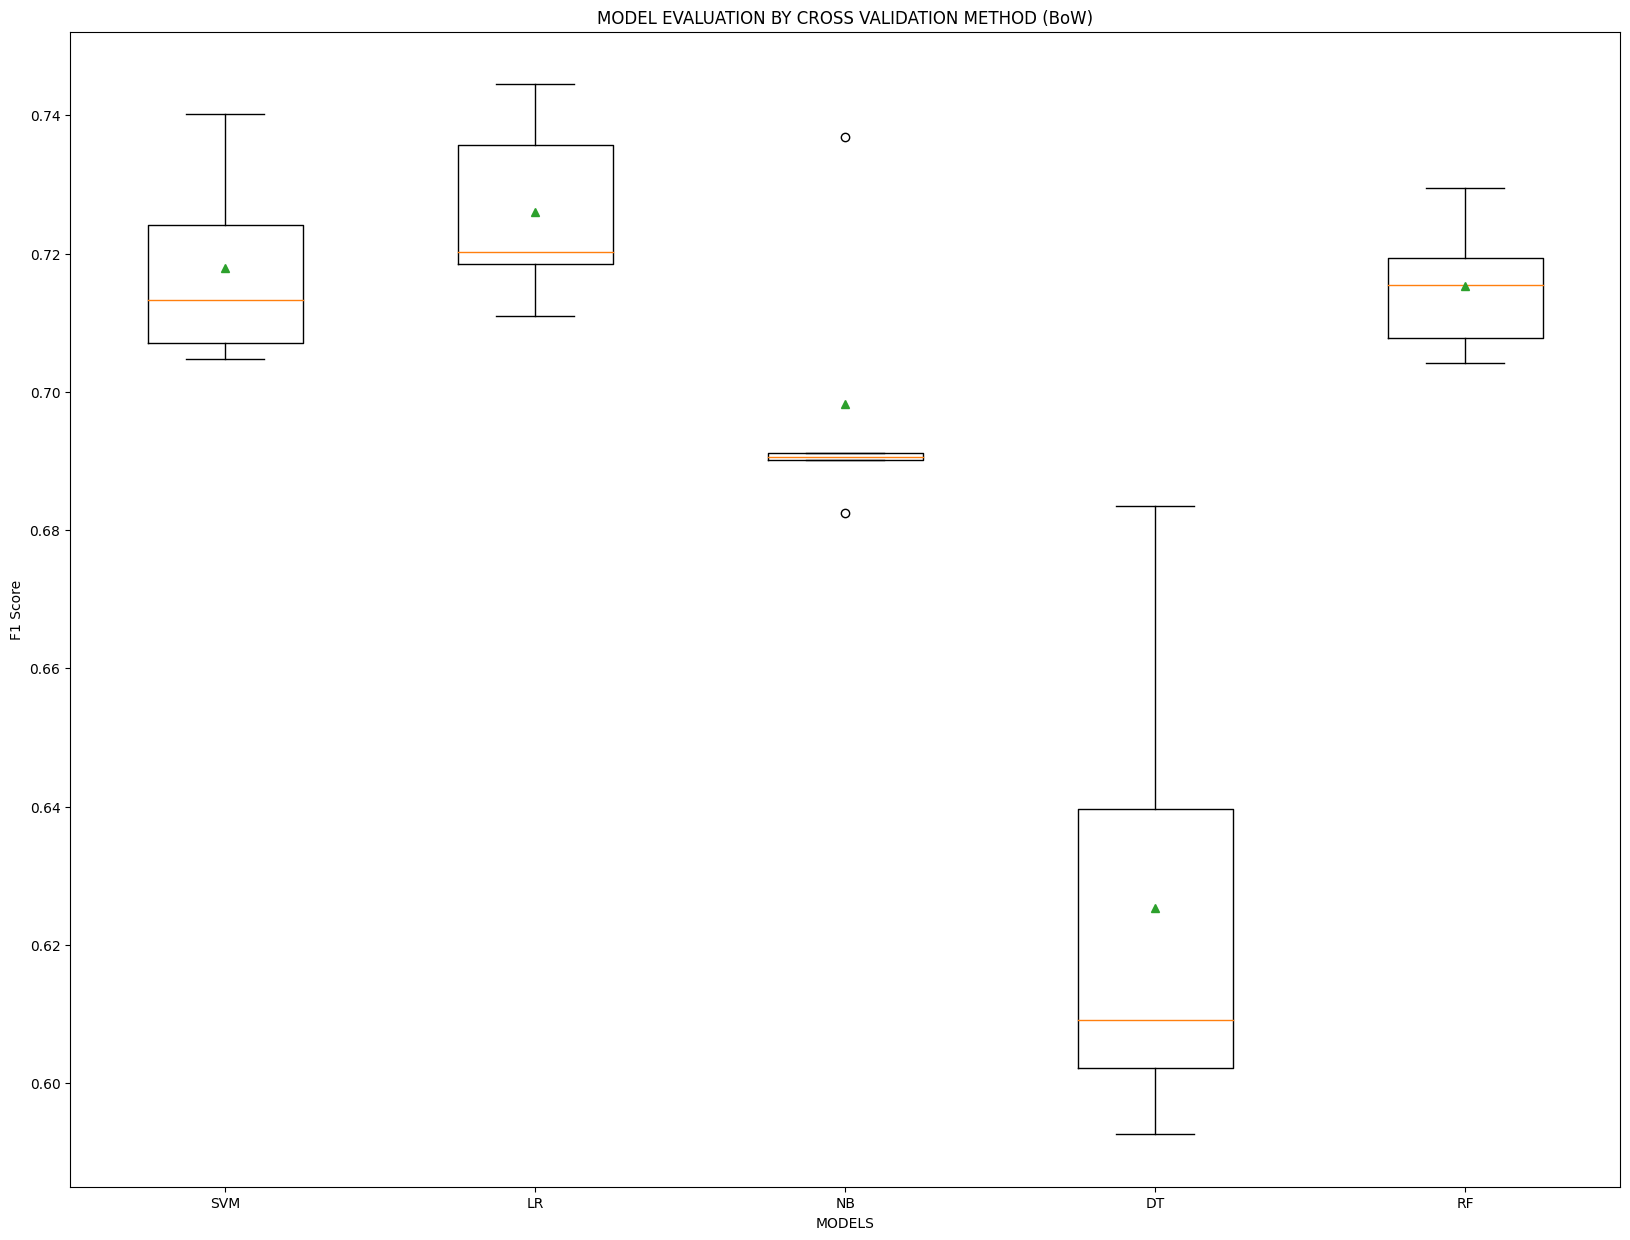

In [ ]:
# Using cross validation method to avoid overfitting
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import statistics as st

###############################################################################
# Model building
lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
mnb = MultinomialNB(alpha=0.1)
dct = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=1, min_samples_split=5)
rf = RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=200)
svm = SVC(C=10, gamma=0.001, kernel='rbf')

m =[svm,lr,mnb,dct,rf]
model_name=['SVM','LR','NB','DT','RF']

results, mean_results, p, f1_test=list(),list(),list(),list()

################################################################################
#Model fitting,cross-validating and evaluating performance

def algor(model):
    print('\n',i)
    pipe=Pipeline([('model',model)])
    pipe.fit(X_train,Y_train)
    cv=StratifiedKFold(n_splits=5)
    n_scores=cross_val_score(pipe,X_train,Y_train,scoring='f1_weighted',cv=cv,n_jobs=-1,error_score='raise') # As it is an Imbalance data so f1 score will give a better accuracy than normal accuracy.
    results.append(n_scores)
    mean_results.append(st.mean(n_scores))
    print('f1-Score(train): mean= (%.3f), min=(%.3f)) ,max= (%.3f), stdev= (%.3f)'%(st.mean(n_scores), min(n_scores), max(n_scores),np.std(n_scores)))
    y_pred=cross_val_predict(model,X_train,Y_train,cv=cv)
    p.append(y_pred)
    f1=f1_score(Y_train,y_pred, average = 'weighted')
    f1_test.append(f1)
    print('f1-Score(test): %.4f'%(f1))

for i in m:
    algor(i)

###############################################################################
# Model comparison By Visualizing

fig=plt.subplots(figsize=(20,15))
plt.title('MODEL EVALUATION BY CROSS VALIDATION METHOD (BoW)')
plt.xlabel('MODELS')
plt.ylabel('F1 Score')
plt.boxplot(results,labels=model_name,showmeans=True)
plt.show()


# TF-IDF

In [ ]:
# Split X and Y
X = np.array(df['clean_text_joined'])
Y = np.array(df['label'])

tfidf = TfidfVectorizer()
Xtfidf = tfidf.fit_transform(X)

# Split Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(Xtfidf, Y, test_size = 0.20, random_state = 31)

SVM (with TF-IDF)

In [ ]:
# Find the best hyperparameter for SVM
svmT = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
}

grid_search = GridSearchCV(svmT, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
svmT_pred = best_model.predict(X_test)
svmT_CR = classification_report(Y_test, svmT_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
svmT_accuracy = accuracy_score(Y_test, svmT_pred)
svmT_precision = precision_score(Y_test, svmT_pred)
svmT_recall = recall_score(Y_test, svmT_pred)
svmT_f1score = f1_score(Y_test, svmT_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of SVM:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of SVM', accuracy_score(Y_test, svmT_pred))

print("")
print("-"*20)
print("")

print(svmT_CR)
print("")
print(svmT_accuracy)
print(svmT_precision)
print(svmT_recall)
print(svmT_f1score)

accuracies.append(round(svmT_accuracy, 4) * 100)
precisions.append(round(svmT_precision, 4) * 100)
recalls.append(round(svmT_recall, 4) * 100)
f1_scores.append(round(svmT_f1score, 4) * 100)

Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.7312775330396477
Best training accuracy of SVM: 0.9991189427312775
Best testing accuracy of SVM 0.7570422535211268

--------------------

              precision    recall  f1-score   support

           0     0.7175    0.7569    0.7366       255
           1     0.7926    0.7572    0.7745       313

    accuracy                         0.7570       568
   macro avg     0.7551    0.7570    0.7556       568
weighted avg     0.7589    0.7570    0.7575       568


0.7570422535211268
0.7926421404682275
0.7571884984025559
0.7745098039215687


LR (with TF-IDF)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
lrT = LogisticRegression(max_iter=1000000, random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear'],  # Solver for logistic regression
}

grid_search = GridSearchCV(lrT, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
lrT_pred = best_model.predict(X_test)
lrT_CR = classification_report(Y_test, lrT_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
lrT_accuracy = accuracy_score(Y_test, lrT_pred)
lrT_precision = precision_score(Y_test, lrT_pred)
lrT_recall = recall_score(Y_test, lrT_pred)
lrT_f1score = f1_score(Y_test, lrT_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of LR:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of LR:', accuracy_score(Y_test, lrT_pred))

print("")
print("-"*20)
print("")

print(lrT_CR)
print("")

print("")
print(lrT_accuracy)
print(lrT_precision)
print(lrT_recall)
print(lrT_f1score)

accuracies.append(round(lrT_accuracy, 4) * 100)
precisions.append(round(lrT_precision, 4) * 100)
recalls.append(round(lrT_recall, 4) * 100)
f1_scores.append(round(lrT_f1score, 4) * 100)

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.7259911894273128
Best training accuracy of LR: 0.9149779735682819
Best testing accuracy of LR: 0.7623239436619719

--------------------

              precision    recall  f1-score   support

           0     0.7308    0.7451    0.7379       255
           1     0.7890    0.7764    0.7826       313

    accuracy                         0.7623       568
   macro avg     0.7599    0.7607    0.7602       568
weighted avg     0.7628    0.7623    0.7625       568



0.7623239436619719
0.788961038961039
0.7763578274760383
0.782608695652174


NB (with TF-IDF)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
nbT = MultinomialNB()

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Example values for the alpha parameter
}

grid_search = GridSearchCV(nbT, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
nbT_pred = best_model.predict(X_test)
nbT_CR = classification_report(Y_test, nbT_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
nbT_accuracy = accuracy_score(Y_test, nbT_pred)
nbT_precision = precision_score(Y_test, nbT_pred)
nbT_recall = recall_score(Y_test, nbT_pred)
nbT_f1score = f1_score(Y_test, nbT_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of NB:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of NB:', accuracy_score(Y_test, nbT_pred))

print("")
print("-"*20)
print("")

print(nbT_CR)
print("")

print("")
print(nbT_accuracy)
print(nbT_precision)
print(nbT_recall)
print(nbT_f1score)

accuracies.append(round(nbT_accuracy, 4) * 100)
precisions.append(round(nbT_precision, 4) * 100)
recalls.append(round(nbT_recall, 4) * 100)
f1_scores.append(round(nbT_f1score, 4) * 100)

Best parameters: {'alpha': 0.1}
Best cross-validation score: 0.6991189427312776
Best training accuracy of LR: 0.9665198237885463
Best testing accuracy of LR: 0.75

--------------------

              precision    recall  f1-score   support

           0     0.7534    0.6588    0.7029       255
           1     0.7478    0.8243    0.7842       313

    accuracy                         0.7500       568
   macro avg     0.7506    0.7416    0.7436       568
weighted avg     0.7503    0.7500    0.7477       568



0.75
0.7478260869565218
0.8242811501597445
0.78419452887538


DT (with TF-IDF)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

dtT = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

grid_search = GridSearchCV(dtT, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
dtT_pred = best_model.predict(X_test)
dtT_CR = classification_report(Y_test, dtT_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
dtT_accuracy = accuracy_score(Y_test, dtT_pred)
dtT_precision = precision_score(Y_test, dtT_pred)
dtT_recall = recall_score(Y_test, dtT_pred)
dtT_f1score = f1_score(Y_test, dtT_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of DT:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of DT:', accuracy_score(Y_test, dtT_pred))

print("")
print("-"*20)
print("")

print(dtT_CR)
print("")

print("")
print(dtT_accuracy)
print(dtT_precision)
print(dtT_recall)
print(dtT_f1score)

accuracies.append(round(dtT_accuracy, 4) * 100)
precisions.append(round(dtT_precision, 4) * 100)
recalls.append(round(dtT_recall, 4) * 100)
f1_scores.append(round(dtT_f1score, 4) * 100)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.6330396475770925
Best training accuracy of LR: 0.7013215859030837
Best testing accuracy of LR: 0.6179577464788732

--------------------

              precision    recall  f1-score   support

           0     0.5511    0.8039    0.6539       255
           1     0.7449    0.4665    0.5737       313

    accuracy                         0.6180       568
   macro avg     0.6480    0.6352    0.6138       568
weighted avg     0.6579    0.6180    0.6097       568



0.6179577464788732
0.7448979591836735
0.46645367412140576
0.5736738703339882


RF (with TF-IDF)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rfT = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

grid_search = GridSearchCV(rfT, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
rfT_pred = best_model.predict(X_test)
rfT_CR = classification_report(Y_test, rfT_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
rfT_accuracy = accuracy_score(Y_test, rfT_pred)
rfT_precision = precision_score(Y_test, rfT_pred)
rfT_recall = recall_score(Y_test, rfT_pred)
rfT_f1score = f1_score(Y_test, rfT_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of RF:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of RF:', accuracy_score(Y_test, rfT_pred))

print("")
print("-"*20)
print("")

print(rfB_CR)
print("")

print("")
print(rfT_accuracy)
print(rfT_precision)
print(rfT_recall)
print(rfT_f1score)

accuracies.append(round(rfT_accuracy, 4) * 100)
precisions.append(round(rfT_precision, 4) * 100)
recalls.append(round(rfT_recall, 4) * 100)
f1_scores.append(round(rfT_f1score, 4) * 100)

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.7242290748898679
Best training accuracy of LR: 0.9753303964757709
Best testing accuracy of LR: 0.7447183098591549

--------------------

              precision    recall  f1-score   support

           0     0.7269    0.6471    0.6846       255
           1     0.7361    0.8019    0.7676       313

    accuracy                         0.7324       568
   macro avg     0.7315    0.7245    0.7261       568
weighted avg     0.7319    0.7324    0.7304       568



0.7447183098591549
0.7560975609756098
0.792332268370607
0.7737909516380657


Cross Validation result


 SVC(C=10, gamma=1)
f1-Score(train): mean= (0.731), min=(0.704)) ,max= (0.762), stdev= (0.020)
f1-Score(test): 0.7313

 LogisticRegression(C=1, solver='liblinear')
f1-Score(train): mean= (0.726), min=(0.701)) ,max= (0.753), stdev= (0.018)
f1-Score(test): 0.7259

 MultinomialNB(alpha=0.1)
f1-Score(train): mean= (0.695), min=(0.670)) ,max= (0.738), stdev= (0.023)
f1-Score(test): 0.6954

 DecisionTreeClassifier(max_depth=10, min_samples_split=10)
f1-Score(train): mean= (0.621), min=(0.606)) ,max= (0.656), stdev= (0.019)
f1-Score(test): 0.6260

 RandomForestClassifier(min_samples_leaf=2)
f1-Score(train): mean= (0.713), min=(0.707)) ,max= (0.719), stdev= (0.005)
f1-Score(test): 0.7136


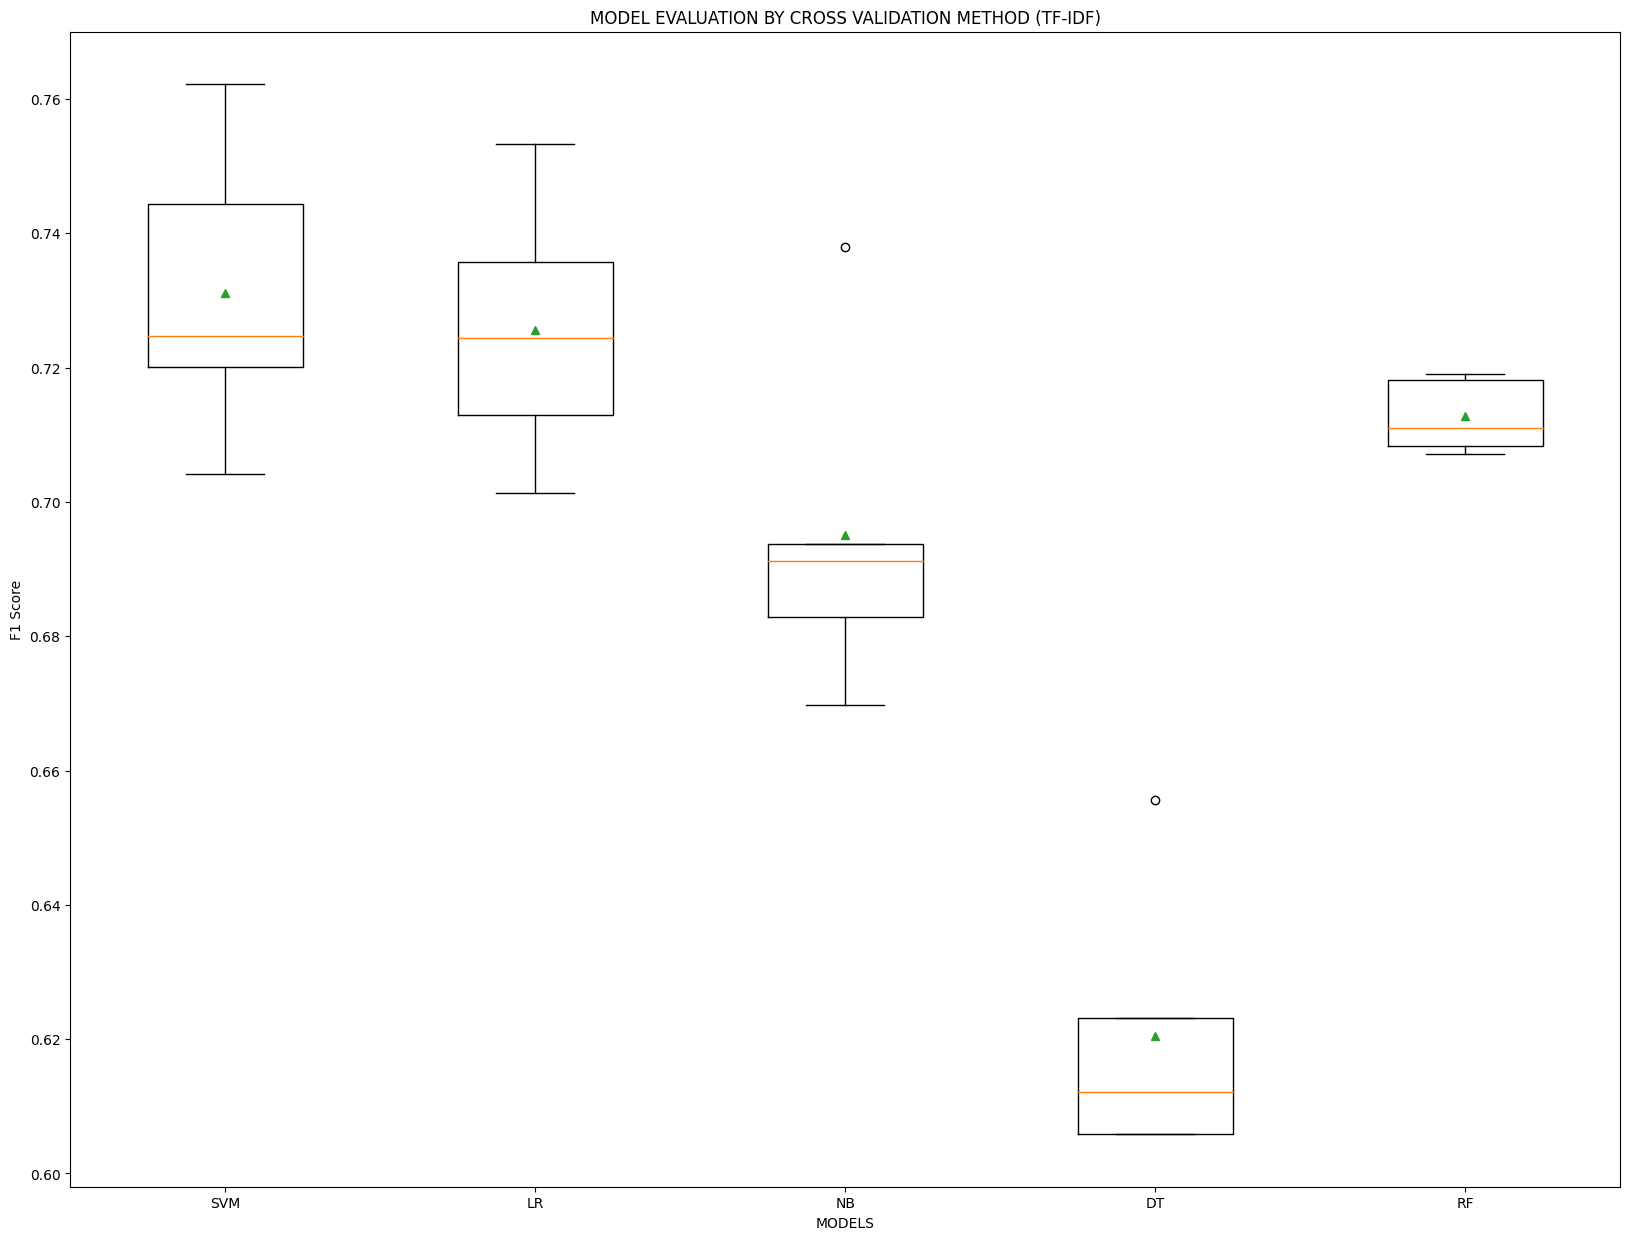

In [ ]:
# Using cross validation method to avoid overfitting
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import statistics as st

###############################################################################
# Model building
lr = LogisticRegression(C=1, penalty='l2', solver='liblinear')
mnb = MultinomialNB(alpha=0.1)
dct = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=10)
rf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
svm = SVC(C=10, gamma=1, kernel='rbf')

m =[svm,lr,mnb,dct,rf]
model_name=['SVM','LR','NB','DT','RF']

results, mean_results, p, f1_test=list(),list(),list(),list()

################################################################################
#Model fitting,cross-validating and evaluating performance

def algor(model):
    print('\n',i)
    pipe=Pipeline([('model',model)])
    pipe.fit(X_train,Y_train)
    cv=StratifiedKFold(n_splits=5)
    n_scores=cross_val_score(pipe,X_train,Y_train,scoring='f1_weighted',cv=cv,n_jobs=-1,error_score='raise') # As it is an Imbalance data so f1 score will give a better accuracy than normal accuracy.
    results.append(n_scores)
    mean_results.append(st.mean(n_scores))
    print('f1-Score(train): mean= (%.3f), min=(%.3f)) ,max= (%.3f), stdev= (%.3f)'%(st.mean(n_scores), min(n_scores), max(n_scores),np.std(n_scores)))
    y_pred=cross_val_predict(model,X_train,Y_train,cv=cv)
    p.append(y_pred)
    f1=f1_score(Y_train,y_pred, average = 'weighted')
    f1_test.append(f1)
    print('f1-Score(test): %.4f'%(f1))

for i in m:
    algor(i)

###############################################################################
# Model comparison By Visualizing

fig=plt.subplots(figsize=(20,15))
plt.title('MODEL EVALUATION BY CROSS VALIDATION METHOD (TF-IDF)')
plt.xlabel('MODELS')
plt.ylabel('F1 Score')
plt.boxplot(results,labels=model_name,showmeans=True)
plt.show()


# Word2vec

In [ ]:
# # Split X and Y
# X = np.array(df['clean_text_joined'])
# Y = np.array(df['label'])

In [ ]:
# import nltk
# nltk.download('punkt')

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# set embedding size
embedding_size = 100

# create and train word2vec model
model = Word2Vec(sentences=df['clean_text'].tolist(), vector_size=embedding_size, window=5, min_count=1, workers=4)

# Convert sentences to averaged Word2Vec vectors
def sentence_to_vector(sentence):
    tokens = [word for word in sentence if word in model.wv]
    vectors = [model.wv[word] for word in tokens]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * embedding_size

# Apply the function to the DataFrame
df['word2vec_vector'] = df['clean_text'].apply(sentence_to_vector)
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,clean_text,clean_text_joined,word2vec_vector
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,"[said, felt, way, suggeted, rest, trigger, ahe...",said felt way suggeted rest trigger ahead youi...,"[-0.18670186, 0.23892231, 0.020090373, 0.06829..."
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,"[hey, assistance, sure, right, place, post, go...",hey assistance sure right place post go curren...,"[-0.19689317, 0.2525583, 0.02266728, 0.0698339..."
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,"[mom, hit, newspaper, shocked, know, like, pla...",mom hit newspaper shocked know like play hitti...,"[-0.26825333, 0.34130636, 0.029004345, 0.10005..."
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,"[met, new, boyfriend, amazing, kind, sweet, go...",met new boyfriend amazing kind sweet good stud...,"[-0.3140368, 0.40474132, 0.038711783, 0.117087..."
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,"[october, domestic, violence, awareness, month...",october domestic violence awareness month dome...,"[-0.17814727, 0.22275524, 0.018347446, 0.06482..."


In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df['word2vec_vector'].tolist(), df['label'], test_size=0.2, random_state=42)

SVM (with word2vec)

In [ ]:
# Find the best hyperparameter for SVM
svmW = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
}

grid_search = GridSearchCV(svmW, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
svmW_pred = best_model.predict(X_test)
svmW_CR = classification_report(Y_test, svmW_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
svmW_accuracy = accuracy_score(Y_test, svmW_pred)
svmW_precision = precision_score(Y_test, svmW_pred)
svmW_recall = recall_score(Y_test, svmW_pred)
svmW_f1score = f1_score(Y_test, svmW_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of SVM:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of SVM', accuracy_score(Y_test, svmW_pred))

print("")
print("-"*20)
print("")

print(svmW_CR)

accuracies.append(round(svmW_accuracy, 4) * 100)
precisions.append(round(svmW_precision, 4) * 100)
recalls.append(round(svmW_recall, 4) * 100)
f1_scores.append(round(svmW_f1score, 4) * 100)

Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.5969162995594713
Best training accuracy of SVM: 0.6066079295154185
Best testing accuracy of SVM 0.579225352112676

--------------------

              precision    recall  f1-score   support

           0     0.5536    0.4715    0.5092       263
           1     0.5959    0.6721    0.6317       305

    accuracy                         0.5792       568
   macro avg     0.5748    0.5718    0.5705       568
weighted avg     0.5763    0.5792    0.5750       568



LR (with word2vec)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
lrW = LogisticRegression(max_iter=1000000, random_state=42)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear'],  # Solver for logistic regression
}

grid_search = GridSearchCV(lrW, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
lrW_pred = best_model.predict(X_test)
lrW_CR = classification_report(Y_test, lrW_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
lrW_accuracy = accuracy_score(Y_test, lrW_pred)
lrW_precision = precision_score(Y_test, lrW_pred)
lrW_recall = recall_score(Y_test, lrW_pred)
lrW_f1score = f1_score(Y_test, lrW_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of LR:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of LR:', accuracy_score(Y_test, lrW_pred))

print("")
print("-"*20)
print("")

print(lrW_CR)
print("")

print("")
print(lrW_accuracy)
print(lrW_precision)
print(lrW_recall)
print(lrW_f1score)

accuracies.append(round(lrW_accuracy, 4) * 100)
precisions.append(round(lrW_precision, 4) * 100)
recalls.append(round(lrW_recall, 4) * 100)
f1_scores.append(round(lrW_f1score, 4) * 100)

Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.6740088105726872
Best training accuracy of LR: 0.7044052863436123
Best testing accuracy of LR: 0.6566901408450704

--------------------

              precision    recall  f1-score   support

           0     0.6308    0.6236    0.6272       263
           1     0.6786    0.6852    0.6819       305

    accuracy                         0.6567       568
   macro avg     0.6547    0.6544    0.6545       568
weighted avg     0.6564    0.6567    0.6565       568



0.6566901408450704
0.6785714285714286
0.6852459016393443
0.6818923327895595


NB (with word2vec)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
nbW = GaussianNB()

param_grid = {
    'priors': [None],  # You can specify your priors if needed
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search = GridSearchCV(nbW, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
nbW_pred = best_model.predict(X_test)
nbW_CR = classification_report(Y_test, nbW_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
nbW_accuracy = accuracy_score(Y_test, nbW_pred)
nbW_precision = precision_score(Y_test, nbW_pred)
nbW_recall = recall_score(Y_test, nbW_pred)
nbW_f1score = f1_score(Y_test, nbW_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of NB:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of NB:', accuracy_score(Y_test, nbW_pred))

print("")
print("-"*20)
print("")

print(nbW_CR)
print("")

print("")
print(nbW_accuracy)
print(nbW_precision)
print(nbW_recall)
print(nbW_f1score)

accuracies.append(round(nbW_accuracy, 4) * 100)
precisions.append(round(nbW_precision, 4) * 100)
recalls.append(round(nbW_recall, 4) * 100)
f1_scores.append(round(nbW_f1score, 4) * 100)

Best parameters: {'priors': None, 'var_smoothing': 1e-09}
Best cross-validation score: 0.5898678414096916
Best training accuracy of LR: 0.5903083700440529
Best testing accuracy of LR: 0.5809859154929577

--------------------

              precision    recall  f1-score   support

           0     0.5556    0.4753    0.5123       263
           1     0.5977    0.6721    0.6327       305

    accuracy                         0.5810       568
   macro avg     0.5766    0.5737    0.5725       568
weighted avg     0.5782    0.5810    0.5770       568



0.5809859154929577
0.597667638483965
0.6721311475409836
0.6327160493827161


DT (with Word2vec)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

dtW = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

grid_search = GridSearchCV(dtW, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
dtW_pred = best_model.predict(X_test)
dtW_CR = classification_report(Y_test, dtW_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
dtW_accuracy = accuracy_score(Y_test, dtW_pred)
dtW_precision = precision_score(Y_test, dtW_pred)
dtW_recall = recall_score(Y_test, dtW_pred)
dtW_f1score = f1_score(Y_test, dtW_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of DT:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of DT:', accuracy_score(Y_test, dtW_pred))

print("")
print("-"*20)
print("")

print(dtW_CR)
print("")

print("")
print(dtW_accuracy)
print(dtW_precision)
print(dtW_recall)
print(dtW_f1score)

accuracies.append(round(dtW_accuracy, 4) * 100)
precisions.append(round(dtW_precision, 4) * 100)
recalls.append(round(dtW_recall, 4) * 100)
f1_scores.append(round(dtW_f1score, 4) * 100)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation score: 0.5806167400881057
Best training accuracy of LR: 0.771806167400881
Best testing accuracy of LR: 0.5369718309859155

--------------------

              precision    recall  f1-score   support

           0     0.5000    0.5171    0.5084       263
           1     0.5709    0.5541    0.5624       305

    accuracy                         0.5370       568
   macro avg     0.5355    0.5356    0.5354       568
weighted avg     0.5381    0.5370    0.5374       568



0.5369718309859155
0.5709459459459459
0.5540983606557377
0.5623960066555741


RF (with Word2vec)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rfW = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
}

grid_search = GridSearchCV(rfW, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Get the best Parameter
best_params = grid_search.best_params_

# Mean cross-validated score
best_cv_score = grid_search.best_score_

# Get the best model
best_model = grid_search.best_estimator_

# Get the best model score
best_model_score = best_model.score(X_test, Y_test)

# Classification report
rfW_pred = best_model.predict(X_test)
rfW_CR = classification_report(Y_test, rfW_pred, digits=4)

#calculate accuracy, precision, recall, f1 score
rfW_accuracy = accuracy_score(Y_test, rfW_pred)
rfW_precision = precision_score(Y_test, rfW_pred)
rfW_recall = recall_score(Y_test, rfW_pred)
rfW_f1score = f1_score(Y_test, rfW_pred)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print('Best training accuracy of RF:', accuracy_score(Y_train, best_model.predict(X_train)))
print('Best testing accuracy of RF:', accuracy_score(Y_test, rfW_pred))

print("")
print("-"*20)
print("")

print(rfW_CR)
print("")

print("")
print(rfW_accuracy)
print(rfW_precision)
print(rfW_recall)
print(rfW_f1score)

accuracies.append(round(rfW_accuracy, 4) * 100)
precisions.append(round(rfW_precision, 4) * 100)
recalls.append(round(rfW_recall, 4) * 100)
f1_scores.append(round(rfW_f1score, 4) * 100)

Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.6396475770925111
Best training accuracy of LR: 0.986784140969163
Best testing accuracy of LR: 0.6267605633802817

--------------------

              precision    recall  f1-score   support

           0     0.6000    0.5817    0.5907       263
           1     0.6486    0.6656    0.6570       305

    accuracy                         0.6268       568
   macro avg     0.6243    0.6237    0.6238       568
weighted avg     0.6261    0.6268    0.6263       568



0.6267605633802817
0.6485623003194888
0.6655737704918033
0.656957928802589



 SVC(C=10, gamma=1)
f1-Score(train): mean= (0.591), min=(0.568)) ,max= (0.628), stdev= (0.022)
f1-Score(test): 0.5922

 LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear')
f1-Score(train): mean= (0.674), min=(0.634)) ,max= (0.698), stdev= (0.022)
f1-Score(test): 0.6735

 GaussianNB()
f1-Score(train): mean= (0.585), min=(0.566)) ,max= (0.609), stdev= (0.016)
f1-Score(test): 0.5852

 DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10)
f1-Score(train): mean= (0.556), min=(0.540)) ,max= (0.570), stdev= (0.011)
f1-Score(test): 0.5583

 RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200)
f1-Score(train): mean= (0.629), min=(0.596)) ,max= (0.651), stdev= (0.020)
f1-Score(test): 0.6292


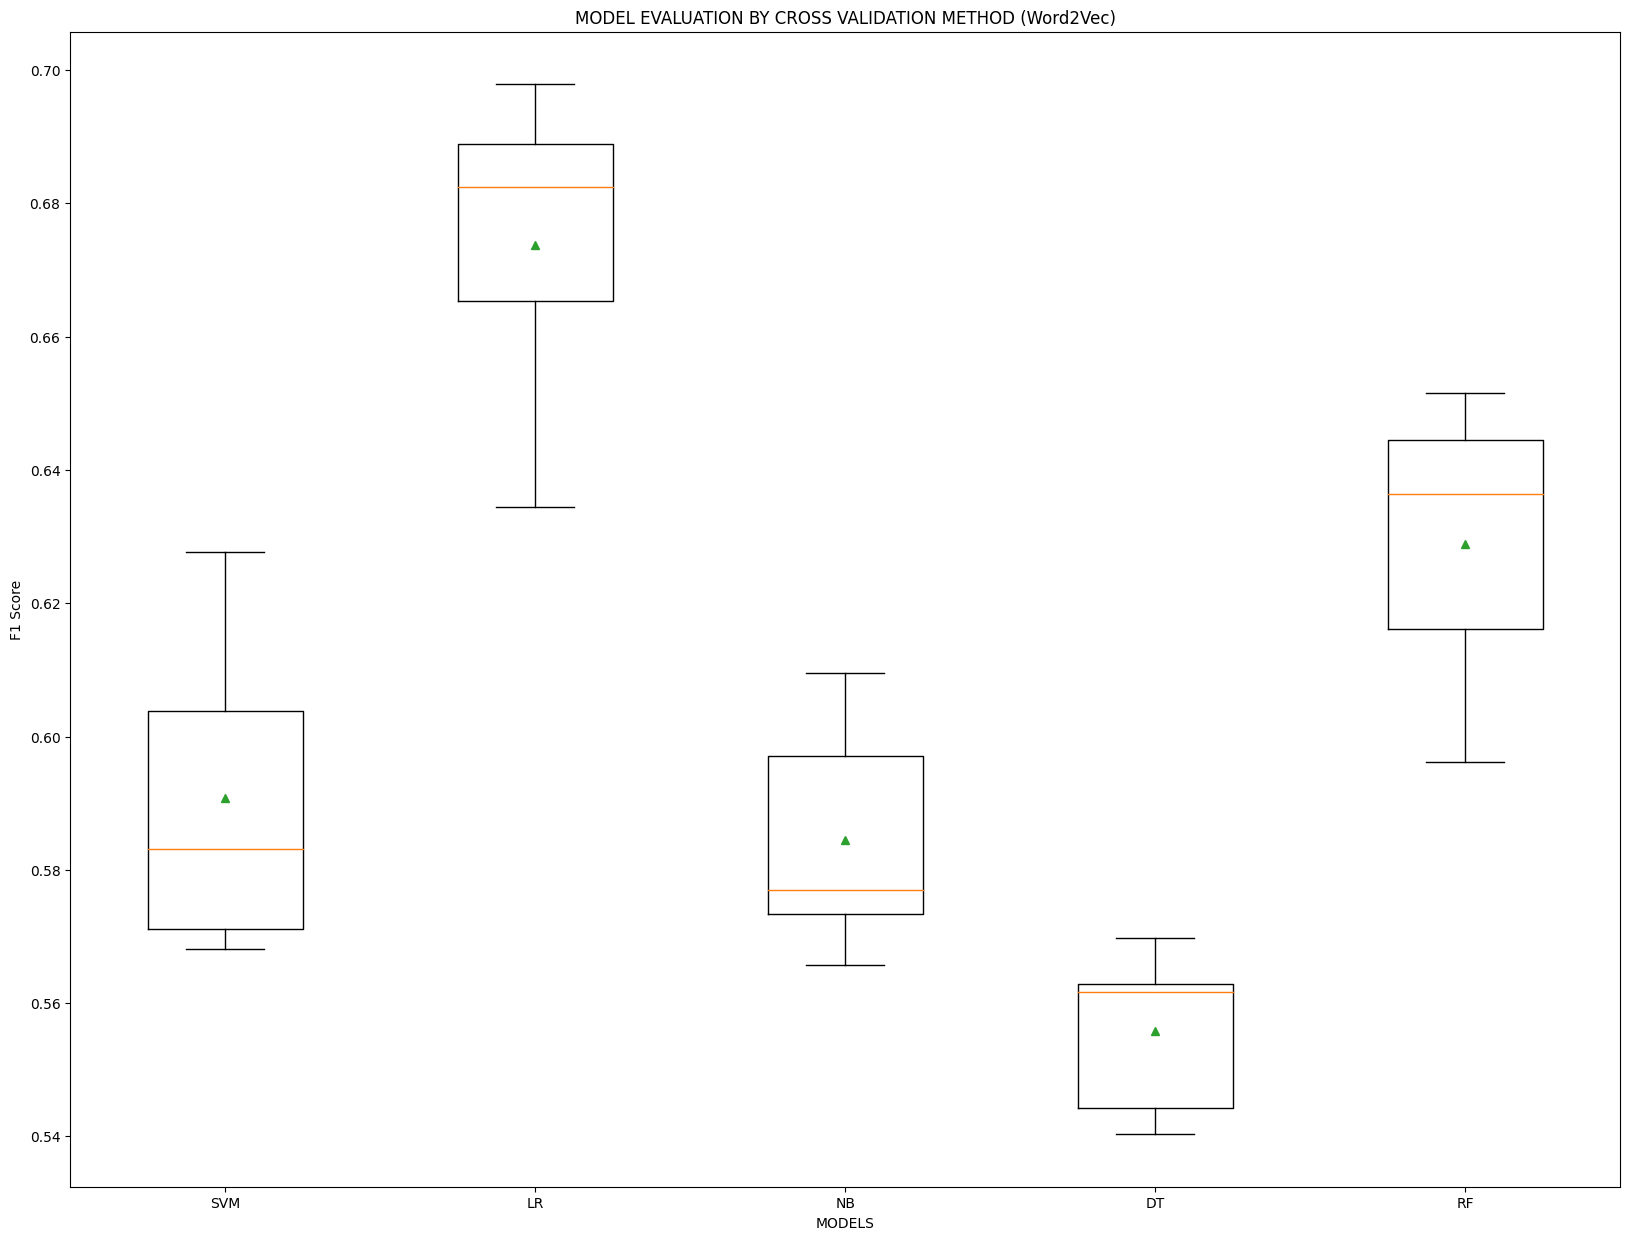

In [ ]:
# Using cross validation method to avoid overfitting
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
import statistics as st

###############################################################################
# Model building
svm = SVC(C=10, gamma=1, kernel='rbf')
lr = LogisticRegression(C=100, penalty='l1', solver='liblinear',max_iter=1000)
nb = GaussianNB(var_smoothing=1e-09)
dct = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=4, min_samples_split=10)
rf = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200)

m =[svm,lr,nb,dct,rf]
model_name=['SVM','LR','NB','DT','RF']

results, mean_results, p, f1_test=list(),list(),list(),list()

################################################################################
#Model fitting,cross-validating and evaluating performance

def algor(model):
    print('\n',i)
    pipe=Pipeline([('model',model)])
    pipe.fit(X_train,Y_train)
    cv=StratifiedKFold(n_splits=5)
    n_scores=cross_val_score(pipe,X_train,Y_train,scoring='f1_weighted',cv=cv,n_jobs=-1,error_score='raise') # As it is an Imbalance data so f1 score will give a better accuracy than normal accuracy.
    results.append(n_scores)
    mean_results.append(st.mean(n_scores))
    print('f1-Score(train): mean= (%.3f), min=(%.3f)) ,max= (%.3f), stdev= (%.3f)'%(st.mean(n_scores), min(n_scores), max(n_scores),np.std(n_scores)))
    y_pred=cross_val_predict(model,X_train,Y_train,cv=cv)
    p.append(y_pred)
    f1=f1_score(Y_train,y_pred, average = 'weighted')
    f1_test.append(f1)
    print('f1-Score(test): %.4f'%(f1))

for i in m:
    algor(i)

###############################################################################
# Model comparison By Visualizing

fig=plt.subplots(figsize=(20,15))
plt.title('MODEL EVALUATION BY CROSS VALIDATION METHOD (Word2Vec)')
plt.xlabel('MODELS')
plt.ylabel('F1 Score')
plt.boxplot(results,labels=model_name,showmeans=True)
plt.show()


LSTM (Word2vec)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(df['word2vec_vector'].tolist())

# Pad sequences to ensure uniform length
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
71/71 [==============================] - 43s 443ms/step - loss: 0.6930 - accuracy: 0.5181 - val_loss: 0.6905 - val_accuracy: 0.5370
Epoch 2/10
71/71 [==============================] - 31s 436ms/step - loss: 0.6927 - accuracy: 0.5211 - val_loss: 0.6904 - val_accuracy: 0.5370
Epoch 3/10
71/71 [==============================] - 32s 459ms/step - loss: 0.6925 - accuracy: 0.5211 - val_loss: 0.6914 - val_accuracy: 0.5370
Epoch 4/10
71/71 [==============================] - 31s 439ms/step - loss: 0.6929 - accuracy: 0.5211 - val_loss: 0.6911 - val_accuracy: 0.5370
Epoch 5/10
71/71 [==============================] - 31s 444ms/step - loss: 0.6926 - accuracy: 0.5211 - val_loss: 0.6913 - val_accuracy: 0.5370
Epoch 6/10
71/71 [==============================] - 32s 452ms/step - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6908 - val_accuracy: 0.5370
Epoch 7/10
71/71 [==============================] - 30s 421ms/step - loss: 0.6922 - accuracy: 0.5211 - val_loss: 0.6922 - val_accuracy: 0.5370

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 128)          66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118081 (461.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,Y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,Y_test)[1]*100 , "%")

71/71 [==============================] - 10s 147ms/step - loss: 0.6921 - accuracy: 0.5211
Accuracy of the model on Training Data is -  52.114540338516235 %
18/18 [==============================] - 2s 87ms/step - loss: 0.6905 - accuracy: 0.5370
Accuracy of the model on Testing Data is -  53.69718074798584 %


In [ ]:
model_prediction = model.predict(X_test)
binary_predictions = (model_prediction > 0.5).astype(int)

accuracy = accuracy_score(Y_test, binary_predictions)
precision = precision_score(Y_test, binary_predictions)
recall = recall_score(Y_test, binary_predictions)
f1 = f1_score(Y_test, binary_predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

18/18 [==============================] - 1s 52ms/step
Accuracy: 0.5370
Precision: 0.5370
Recall: 1.0000
F1 Score: 0.6987


CNN (Word2vec)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming df['word2vec_vector'] contains Word2Vec vectors for each sentence

# Convert the Word2Vec vectors to numpy arrays
X = np.array(df['word2vec_vector'].tolist())

# Pad sequences to ensure uniform length
X = pad_sequences(X)

# Reshape the input to add a channel dimension
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

# Build a CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/10
71/71 [==============================] - 3s 20ms/step - loss: 0.6901 - accuracy: 0.5211 - val_loss: 0.6838 - val_accuracy: 0.5370
Epoch 2/10
71/71 [==============================] - 1s 14ms/step - loss: 0.6887 - accuracy: 0.5211 - val_loss: 0.6849 - val_accuracy: 0.5370
Epoch 3/10
71/71 [==============================] - 1s 10ms/step - loss: 0.6886 - accuracy: 0.5211 - val_loss: 0.6853 - val_accuracy: 0.5370
Epoch 4/10
71/71 [==============================] - 1s 10ms/step - loss: 0.6884 - accuracy: 0.5211 - val_loss: 0.6833 - val_accuracy: 0.5370
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.6889 - accuracy: 0.5211 - val_loss: 0.6855 - val_accuracy: 0.5370
Epoch 6/10
71/71 [==============================] - 1s 10ms/step - loss: 0.6885 - accuracy: 0.5211 - val_loss: 0.6836 - val_accuracy: 0.5370
Epoch 7/10
71/71 [==============================] - 1s 10ms/step - loss: 0.6883 - accuracy: 0.5211 - val_loss: 0.6835 - val_accuracy: 0.5370
Epoch 8/10
71/

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 98, 64)            256       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_5 (Dense)             (None, 100)               313700    
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 314057 (1.20 MB)
Trainable params: 314057 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,Y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,Y_test)[1]*100 , "%")

71/71 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5211
Accuracy of the model on Training Data is -  52.114540338516235 %
18/18 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.5370
Accuracy of the model on Testing Data is -  53.69718074798584 %


In [ ]:
model_prediction = model.predict(X_test)
binary_predictions = (model_prediction > 0.5).astype(int)

accuracy = accuracy_score(Y_test, binary_predictions)
precision = precision_score(Y_test, binary_predictions)
recall = recall_score(Y_test, binary_predictions)
f1 = f1_score(Y_test, binary_predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

18/18 [==============================] - 0s 4ms/step
Accuracy: 0.5370
Precision: 0.5370
Recall: 1.0000
F1 Score: 0.6987


# GloVe (Deep Learning)

In [ ]:
# Split X and Y
X = np.array(df['clean_text_joined'])
Y = np.array(df['label'])

# split data
x_train,x_test,y_train,y_test = train_test_split(df.clean_text_joined,df.label,random_state = 0)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')

# Assuming x_train is a NumPy array containing text samples and max_features and maxlen are defined
max_features = 10000  # Adjust as needed
maxlen = 200  # Adjust as needed

# Convert the NumPy array to a list of strings
x_train_list = x_train.astype(str).tolist()

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train_list)
tokenized_train = tokenizer.texts_to_sequences(x_train_list)
x_train_padded = pad_sequences(tokenized_train, maxlen=maxlen)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
print(x_train_padded.dtype)
print(X_test.dtype)

int32
int32


In [ ]:
EMBEDDING_FILE = '/content/drive/My Drive/glove.twitter.27B.200d.txt'

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
# all_embs = np.stack(embeddings_index.values())
# emb_mean, emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]

# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))

# embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# for word, i in word_index.items():
#     if i < max_features:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i - 1] = embedding_vector  # Subtract 1 from i to ensure correct zero-based indexing

# # Verify the shape of embedding_matrix
# print(embedding_matrix.shape)


In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))

for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Verify the shape of embedding_matrix
print(embedding_matrix.shape)


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(10000, 200)


In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

LSTM

In [ ]:
model=Sequential()
model.add(Embedding(max_features,output_dim=200,weights=[embedding_matrix],input_length=maxlen,trainable=False))
#change output_dim if take small glove

#LSTM
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.25,dropout=0.25))
model.add(LSTM(units=64,recurrent_dropout=0.1,dropout=0.1))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 200)          2000000   
                                                                 
 lstm_4 (LSTM)               (None, 200, 128)          168448    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2219969 (8.47 MB)
Trainable params: 219969 (859.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________________________________________________________


In [ ]:
print(y_train.dtype)
print(y_test.dtype)
print(x_test.dtype)
print(x_train.dtype)

int64
int64
object
object


In [ ]:
import numpy as np

print("Train label unique values:", np.unique(y_train))
print("Test label unique values:", np.unique(y_test))


Train label unique values: [0 1]
Test label unique values: [0 1]


In [ ]:
history=model.fit(x_train_padded,y_train,batch_size=batch_size,
                  validation_data=(X_test,y_test),epochs=epochs,
                  callbacks=[learning_rate_reduction])


Epoch 1/10
9/9 [==============================] - 61s 6s/step - loss: 0.6942 - accuracy: 0.5489 - val_loss: 0.6187 - val_accuracy: 0.6775 - lr: 0.0100
Epoch 2/10
9/9 [==============================] - 46s 5s/step - loss: 0.6076 - accuracy: 0.6753 - val_loss: 0.5718 - val_accuracy: 0.7197 - lr: 0.0100
Epoch 3/10
9/9 [==============================] - 56s 6s/step - loss: 0.5486 - accuracy: 0.7086 - val_loss: 0.5117 - val_accuracy: 0.7451 - lr: 0.0100
Epoch 4/10
9/9 [==============================] - 46s 5s/step - loss: 0.5040 - accuracy: 0.7556 - val_loss: 0.5064 - val_accuracy: 0.7507 - lr: 0.0100
Epoch 5/10
9/9 [==============================] - 49s 6s/step - loss: 0.4502 - accuracy: 0.7857 - val_loss: 0.5164 - val_accuracy: 0.7521 - lr: 0.0100
Epoch 6/10
9/9 [==============================] - 57s 6s/step - loss: 0.4277 - accuracy: 0.8106 - val_loss: 0.5350 - val_accuracy: 0.7254 - lr: 0.0100
Epoch 7/10
9/9 [==============================] - 51s 6s/step - loss: 0.3796 - accuracy: 0.832

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train_padded,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

67/67 [==============================] - 18s 264ms/step - loss: 0.1347 - accuracy: 0.9586
Accuracy of the model on Training Data is -  95.86465954780579 %
23/23 [==============================] - 6s 250ms/step - loss: 0.7577 - accuracy: 0.7366
Accuracy of the model on Testing Data is -  73.66197109222412 %


In [ ]:
model_prediction = model.predict(X_test)
binary_predictions = (model_prediction > 0.5).astype(int)

accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

23/23 [==============================] - 6s 236ms/step
Accuracy: 0.7366
Precision: 0.7987
Recall: 0.6684
F1 Score: 0.7278


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# model = Sequential()

# # Embedding layer with pre-trained weights
# model.add(Embedding(max_features, output_dim=50, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# # Convolutional layers
# model.add(Conv1D(128, kernel_size=5, activation='relu'))
# model.add(GlobalMaxPooling1D())

# # Dense layers
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# model.summary()

CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

# Assuming max_features, output_dim, embedding_matrix, maxlen are defined

batch_size = 256
epochs = 10
embed_size = 100

model = Sequential()
model.add(Embedding(max_features, output_dim=200, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# CNN layers
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())  # Global max pooling layer
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 200)          2000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 198, 128)          76928     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 99, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 97, 64)            24640     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 32)               

In [ ]:
history=model.fit(x_train_padded,y_train,batch_size=batch_size,
                  validation_data=(X_test,y_test),epochs=epochs,
                  callbacks=[learning_rate_reduction])

Epoch 1/10
9/9 [==============================] - 9s 840ms/step - loss: 1.0059 - accuracy: 0.5193 - val_loss: 0.7773 - val_accuracy: 0.4732 - lr: 0.0100
Epoch 2/10
9/9 [==============================] - 5s 522ms/step - loss: 0.6884 - accuracy: 0.5456 - val_loss: 0.6496 - val_accuracy: 0.6028 - lr: 0.0100
Epoch 3/10
9/9 [==============================] - 7s 823ms/step - loss: 0.6045 - accuracy: 0.6593 - val_loss: 0.6333 - val_accuracy: 0.6549 - lr: 0.0100
Epoch 4/10
9/9 [==============================] - 8s 850ms/step - loss: 0.5766 - accuracy: 0.7044 - val_loss: 0.5402 - val_accuracy: 0.7437 - lr: 0.0100
Epoch 5/10
9/9 [==============================] - 5s 515ms/step - loss: 0.5008 - accuracy: 0.7528 - val_loss: 0.5408 - val_accuracy: 0.7324 - lr: 0.0100
Epoch 6/10
9/9 [==============================] - 5s 615ms/step - loss: 0.4596 - accuracy: 0.7787 - val_loss: 0.5322 - val_accuracy: 0.7465 - lr: 0.0100
Epoch 7/10
9/9 [==============================] - 7s 737ms/step - loss: 0.3864 - a

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train_padded,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

67/67 [==============================] - 2s 27ms/step - loss: 0.0992 - accuracy: 0.9765
Accuracy of the model on Training Data is -  97.65037298202515 %
23/23 [==============================] - 1s 27ms/step - loss: 0.6629 - accuracy: 0.7352
Accuracy of the model on Testing Data is -  73.52112531661987 %


In [ ]:
model_prediction = model.predict(X_test)
binary_predictions = (model_prediction > 0.5).astype(int)

accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

23/23 [==============================] - 1s 27ms/step
Accuracy: 0.7352
Precision: 0.7193
Recall: 0.8155
F1 Score: 0.7644


# Result (ML)

In [ ]:
models = ["SVM with BoW","LR with BoW","NB with BoW","DT with BoW","RF with BoW",
          "SVM with TF-IDF","LR with TF-IDF","NB with TF-IDF","DT with TF-IDF","RF with TF-IDF",
          "SVM with Word2Vec","LR with Word2Vec","NB with Word2Vec","DT with Word2Vec","RF with Word2Vec"]

metrics = {
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recalls': recalls,
    'F1-Score': f1_scores
}

comparison_table = pd.DataFrame(metrics)

comparison_table

,Model,Accuracy,Precision,Recalls,F1-Score
0,SVM with BoW,73.77,77.52,73.80,75.61
1,LR with BoW,75.70,78.69,76.68,77.67
2,NB with BoW,76.06,74.65,85.62,79.76
3,DT with BoW,62.15,68.56,57.83,62.74
4,RF with BoW,73.24,73.61,80.19,76.76
5,SVM with TF-IDF,75.70,79.26,75.72,77.45
6,LR with TF-IDF,76.23,78.90,77.64,78.26
7,NB with TF-IDF,75.00,74.78,82.43,78.42
8,DT with TF-IDF,61.80,74.49,46.65,57.37
9,RF with TF-IDF,74.47,75.61,79.23,77.38


In [ ]:
comparison_table[['Models', 'Feature_Extraction']] = comparison_table['Model'].str.split(' with ', expand=True)
comparison_table = comparison_table.drop('Model', axis=1)
comparison_table

,Accuracy,Precision,Recalls,F1-Score,Models,Feature_Extraction
0,73.77,77.52,73.80,75.61,SVM,BoW
1,75.70,78.69,76.68,77.67,LR,BoW
2,76.06,74.65,85.62,79.76,NB,BoW
3,62.15,68.56,57.83,62.74,DT,BoW
4,73.24,73.61,80.19,76.76,RF,BoW
5,75.70,79.26,75.72,77.45,SVM,TF-IDF
6,76.23,78.90,77.64,78.26,LR,TF-IDF
7,75.00,74.78,82.43,78.42,NB,TF-IDF
8,61.80,74.49,46.65,57.37,DT,TF-IDF
9,74.47,75.61,79.23,77.38,RF,TF-IDF


In [ ]:
# result will be analyzed in different notebook
comparison_table.to_csv('comparison_table.csv', index=False)

In [ ]:
filtered_df = comparison_table[comparison_table['Feature_Extraction'] == 'BoW']

# Display the filtered DataFrame
print(filtered_df)

   Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
0     73.77      77.52    73.80     75.61    SVM                BoW
1     75.70      78.69    76.68     77.67     LR                BoW
2     76.06      74.65    85.62     79.76     NB                BoW
3     62.15      68.56    57.83     62.74     DT                BoW
4     73.24      73.61    80.19     76.76     RF                BoW


In [ ]:
filtered_df1 = comparison_table[comparison_table['Feature_Extraction'] == 'TF-IDF']

# Display the filtered DataFrame
print(filtered_df1)

   Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
5     75.70      79.26    75.72     77.45    SVM             TF-IDF
6     76.23      78.90    77.64     78.26     LR             TF-IDF
7     75.00      74.78    82.43     78.42     NB             TF-IDF
8     61.80      74.49    46.65     57.37     DT             TF-IDF
9     74.47      75.61    79.23     77.38     RF             TF-IDF


In [ ]:
filtered_df2 = comparison_table[comparison_table['Feature_Extraction'] == 'Word2Vec']

# Display the filtered DataFrame
print(filtered_df2)

    Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
10     57.92      59.59    67.21     63.17    SVM           Word2Vec
11     65.67      67.86    68.52     68.19     LR           Word2Vec
12     58.10      59.77    67.21     63.27     NB           Word2Vec
13     53.70      57.09    55.41     56.24     DT           Word2Vec
14     62.68      64.86    66.56     65.70     RF           Word2Vec


In [ ]:
filtered_df3 = comparison_table[comparison_table['Models'] == 'SVM']

# Display the filtered DataFrame
print(filtered_df3)

    Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
0      73.77      77.52    73.80     75.61    SVM                BoW
5      75.70      79.26    75.72     77.45    SVM             TF-IDF
10     57.92      59.59    67.21     63.17    SVM           Word2Vec


In [ ]:
filtered_df4 = comparison_table[comparison_table['Models'] == 'LR']

# Display the filtered DataFrame
print(filtered_df4)

    Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
1      75.70      78.69    76.68     77.67     LR                BoW
6      76.23      78.90    77.64     78.26     LR             TF-IDF
11     65.67      67.86    68.52     68.19     LR           Word2Vec


In [ ]:
filtered_df5 = comparison_table[comparison_table['Models'] == 'NB']

# Display the filtered DataFrame
print(filtered_df5)

    Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
2      76.06      74.65    85.62     79.76     NB                BoW
7      75.00      74.78    82.43     78.42     NB             TF-IDF
12     58.10      59.77    67.21     63.27     NB           Word2Vec


In [ ]:
filtered_df6 = comparison_table[comparison_table['Models'] == 'DT']

# Display the filtered DataFrame
print(filtered_df6)

    Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
3      62.15      68.56    57.83     62.74     DT                BoW
8      61.80      74.49    46.65     57.37     DT             TF-IDF
13     53.70      57.09    55.41     56.24     DT           Word2Vec


In [ ]:
filtered_df7 = comparison_table[comparison_table['Models'] == 'RF']

# Display the filtered DataFrame
print(filtered_df7)

    Accuracy  Precision  Recalls  F1-Score Models Feature_Extraction
4      73.24      73.61    80.19     76.76     RF                BoW
9      74.47      75.61    79.23     77.38     RF             TF-IDF
14     62.68      64.86    66.56     65.70     RF           Word2Vec


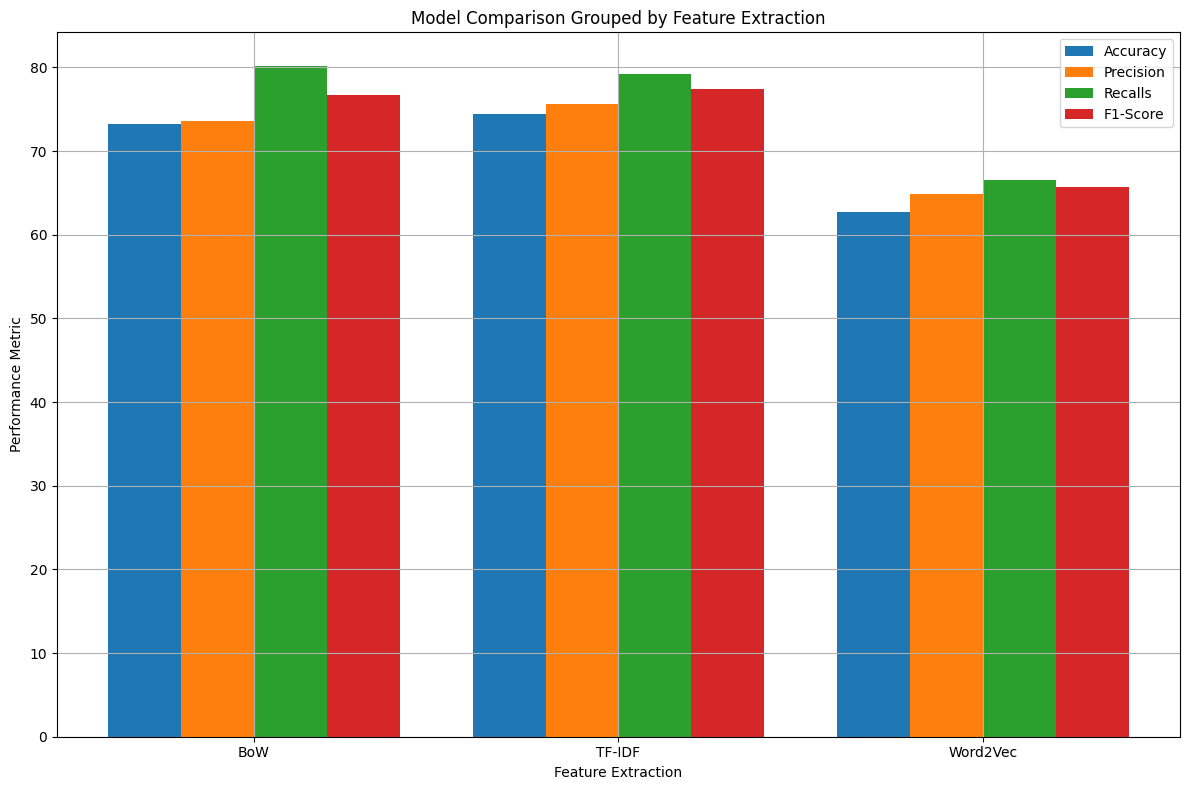

In [ ]:
# Set up subplots
fig, axs = plt.subplots(figsize=(12, 8))

# Define bar width and positions
bar_width = 0.2
bar_positions = range(len(filtered_df7['Feature_Extraction'].unique()))

# Iterate through each metric
for i, metric in enumerate(['Accuracy', 'Precision', 'Recalls', 'F1-Score']):
    # Offset the position for each metric
    offset = bar_width * i
    # Plot the bars for each feature extraction
    axs.bar([pos + offset for pos in bar_positions], filtered_df7.groupby('Feature_Extraction')[metric].mean(), width=bar_width, label=f'{metric}')

# Set plot labels and legend
axs.set_title('Feature Extraction ')
axs.set_xlabel('Feature Extraction')
axs.set_ylabel('Performance Metric')
axs.set_xticks([pos + (bar_width * 1.5) for pos in bar_positions])
axs.set_xticklabels(filtered_df7['Feature_Extraction'].unique())
axs.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Deployment

In [ ]:
# pip install joblib
# find the best model which is Logistic regression with TF-IDF because it hv highest accuracy rate

In [ ]:
# Split X and Y
X = np.array(df['clean_text_joined'])
Y = np.array(df['label'])

tfidf = TfidfVectorizer()
Xtfidf = tfidf.fit_transform(X)

# Split Train and Test
X_train, X_test, Y_train, Y_test = train_test_split(Xtfidf, Y, test_size = 0.20, random_state = 31)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Find the best hyperparameter for LR
lrT = LogisticRegression(max_iter=1000000, random_state=42,C= 1, penalty= 'l2', solver= 'liblinear')

lrT.fit(X_train, Y_train)

print("accuracy:",lrT.score(X_test,Y_test))

accuracy: 0.7623239436619719


In [ ]:
# save the tf-idf in joblib file
import joblib
joblib.dump(tfidf, '/content/tfidf.joblib')

['/content/tfidf.joblib']

In [ ]:
import joblib

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(lemmatizer.lemmatize(token))
    return result


# Input data for prediction
input_data = "i like my boyfriend!"

# Preprocess and transform the input data using the loaded vectorizer
processed_data = preprocess(input_data)
joined_text = [" ".join(processed_data)]

saved_tfidf = joblib.load('/content/tfidf.joblib')

X_train_tfidf = saved_tfidf.transform(joined_text)

prediction = lrT.predict(X_train_tfidf)
print(prediction)

if prediction == 0:
    print("This is not stress content")
else:
    print("This is stress content")

[1]
This is stress content


Saving the trained model

In [ ]:
# # saving the trained model
import pickle

In [ ]:
filename = 'trained_model.sav'
pickle.dump(lrT,open(filename,'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('trained_model.sav','rb'))

In [ ]:
import joblib
import gensim

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(lemmatizer.lemmatize(token))
    return result


# Input data for prediction
input_data = "i like my parent!"

# Preprocess and transform the input data using the loaded vectorizer
processed_data = preprocess(input_data)
joined_text = [" ".join(processed_data)]

saved_tfidf = joblib.load('/content/tfidf.joblib')

X_train_tfidf = saved_tfidf.transform(joined_text)

prediction = loaded_model.predict(X_train_tfidf)
print(prediction)

if prediction == 0:
    print("This is not stress content")
else:
    print("This is stress content")

[0]
This is not stress content
